###imports

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import numpy as np
from tqdm import tqdm

In [ ]:
!pip install -q libpysal

In [ ]:
!pip install -q contextily

In [ ]:
!pip install -q momepy

In [ ]:
# !pip install -q mapclassify

In [ ]:
from libpysal import weights, examples
# from libpysal.cg import voronoi_frames
from contextily import add_basemap
import scipy.io as io

import geopandas
import momepy

###1\. Реализовать алгоритм построения предфрактального графа 4-ой итерации с помощью операции замещения вершины затравкой.

https://www.keldysh.ru/papers/2003/prep83/prep2003_83.html<br>https://cloud.mail.ru/attaches/17109256261452254871%3B0%3B1?folder-id=0&x-email=pi216%40bk.ru&cvg=f

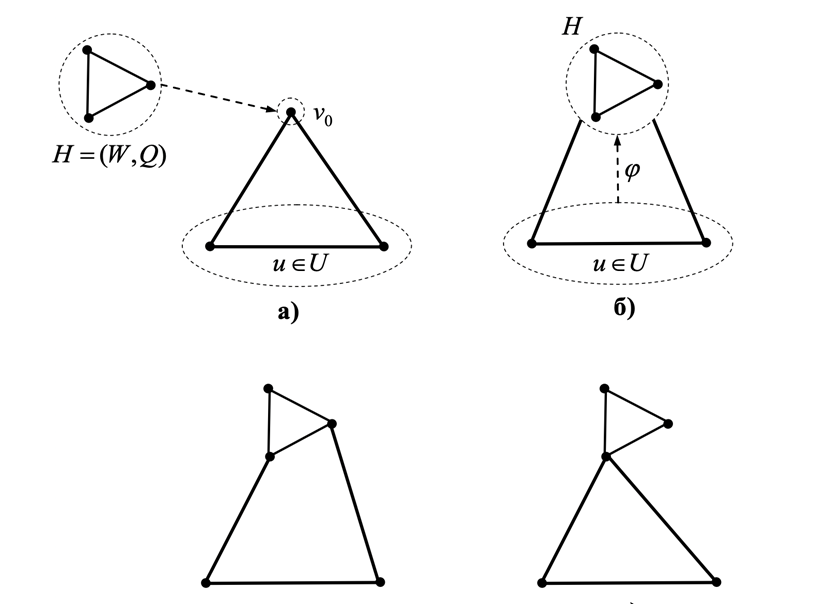

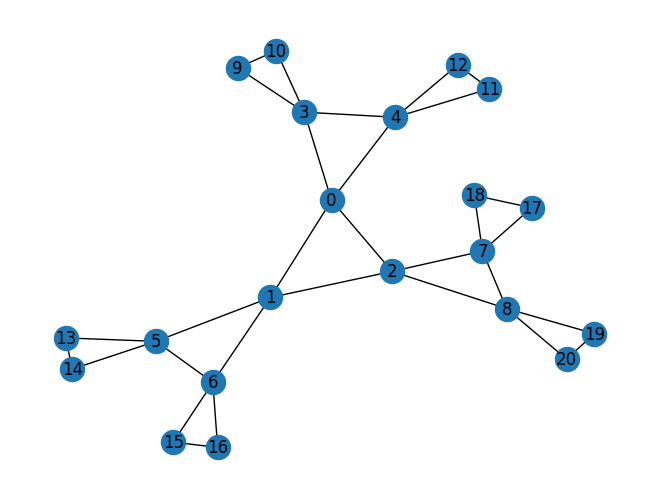

In [ ]:
def fractal_graph(n_iter=4, n_nodes=3):
    G = nx.Graph()
    nx.add_path(G, range(n_nodes)) # base figure
    G.add_edge(0, n_nodes-1)

    for step in range(n_iter):
        new_edges = []
        last_node = len(G)

        for node in list(G.nodes()):
            if G.degree(node) == 2:
                # neighbors = list(G.neighbors(node))
                # print([i for i in range(last_node, last_node + n_nodes - 1)])
                # print(node, last_node+n_nodes-2)

                nx.add_path(G, range(last_node, last_node + n_nodes - 1)) # base figure
                new_edges.extend([(node, last_node + n_nodes - 2), (node, last_node)])

                last_node = len(G)

            # G.remove_edge(edge[0], edge[1])

        G.add_edges_from(new_edges)

    return G

g = fractal_graph(n_iter=2, n_nodes=3)
nx.draw(g, with_labels=True)

[(8, 1, 3), (2, 4, 6), (0, 5, 7)]
[(21, 26, 5), (24, 22, 7), (0, 25, 23)]


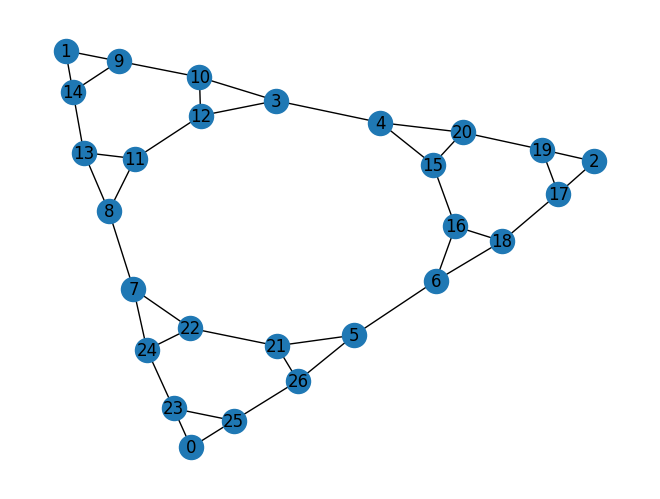

In [ ]:
def fractal_weird_graph(n_iter=4, n_nodes=3):
    G = nx.Graph()
    nx.add_path(G, range(n_nodes)) # base figure
    G.add_edge(0, n_nodes-1)

    triangles = [(0, 1, 2)]

    for step in range(n_iter-1):

        last_node = len(G)

        for triangle in triangles:
            new_edges = []
            neighbors_history = []
            semitriangles = []
            for node in triangle:
                neighbors = list(triangle)
                neighbors.remove(node)
                neighbors_history.append(neighbors)

                new_edges.extend([(neighbors[0], last_node), (last_node, last_node + 1), (last_node + 1, neighbors[1])])
                semitriangles.extend([(neighbors[0], last_node), (last_node + 1, neighbors[1])])

                last_node += 2
            G.add_edges_from(new_edges)

            for old_neighbor in neighbors_history:
                G.remove_edge(old_neighbor[0], old_neighbor[1])

            for i, j in itertools.combinations(semitriangles, 2):
                s = list(set(i).intersection(set(j)))
                if len(s) == 1:
                    triangle = tuple(set([i[0], i[1], j[0], j[1]]))
                    triangle = list(triangle)
                    triangle.remove(s[0])
                    G.add_edge(triangle[0], triangle[1])

        triangles = []
        for i, j in itertools.combinations(semitriangles, 2):
            s = list(set(i).intersection(set(j)))
            if len(s) == 1:
                triangle = tuple(set([i[0], i[1], j[0], j[1]]))
                triangles.append(triangle)

        print(triangles)

    return G

g = fractal_weird_graph(n_iter=3, n_nodes=3)
nx.draw(g, with_labels=True)

[(8, 1, 3), (2, 4, 6), (0, 5, 7)]


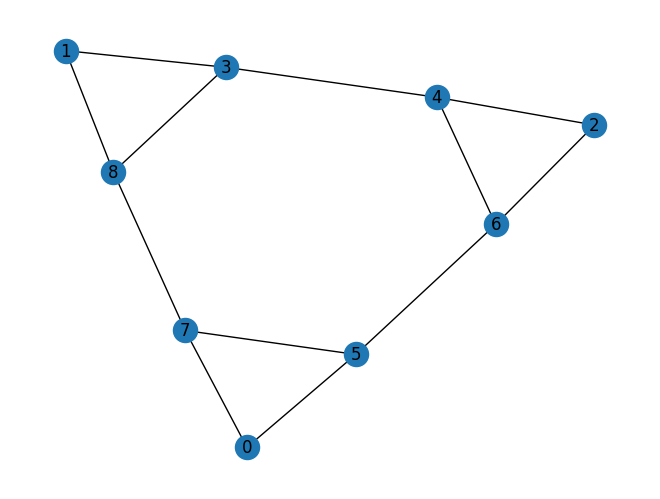

In [ ]:
g = fractal_weird_graph(n_iter=2, n_nodes=3)
nx.draw(g, with_labels=True)

[(8, 1, 3), (2, 4, 6), (0, 5, 7)]
[(21, 26, 5), (24, 22, 7), (0, 25, 23)]
[(25, 44, 39), (40, 42, 23), (0, 41, 43)]


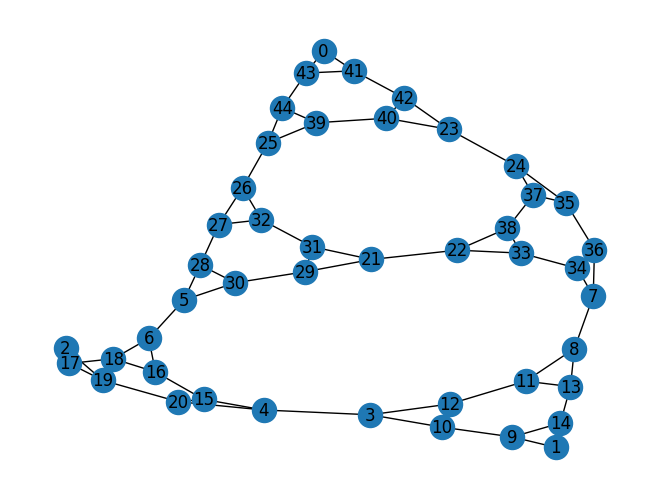

In [ ]:
g = fractal_weird_graph(n_iter=4, n_nodes=3)
nx.draw(g, with_labels=True)

###2\. Выбрать (скачать) самостоятельно датасет (например, с kaggle.com, данные о дорожной сети, транспортных узлах и т.д.) и построить граф с географической привязкой данных.

In [ ]:
rails = geopandas.read_file('/content/drive/MyDrive/Colab Notebooks/МО в семантическом и сетевом анализе/hotosm_che_railways.gpkg')

In [ ]:
rails.geometry.type.unique()

array(['LineString', 'MultiPolygon', 'MultiLineString'], dtype=object)

In [ ]:
rails_1 = rails[rails.geometry.type == 'LineString']

In [ ]:
g = momepy.gdf_to_nx(rails_1)

In [ ]:
rails_1.explore()

Output hidden; open in https://colab.research.google.com to view.

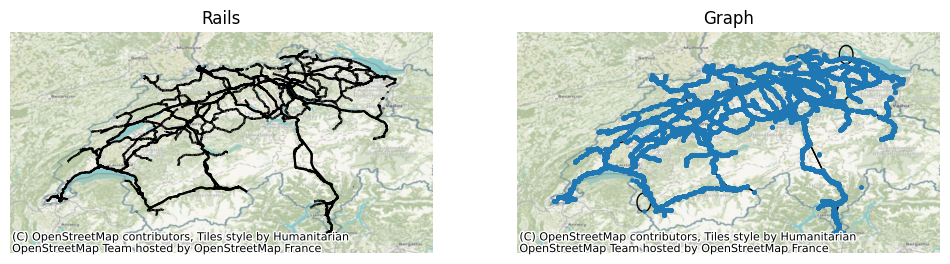

In [ ]:
positions = {n: [n[0], n[1]] for n in list(g.nodes)}

f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
rails_1.plot(color="k", ax=ax[0])
nx.draw(g, positions, ax=ax[1], node_size=5)
for i, facet in enumerate(ax):
    facet.set_title(("Rails", "Graph")[i])
    add_basemap(facet, crs=rails_1.crs)
    facet.axis("off")

In [ ]:
roads = geopandas.read_file(r'/content/drive/MyDrive/Colab Notebooks/МО в семантическом и сетевом анализе/hotosm_lbr_roads_lines_geojson.geojson')

In [ ]:
roads[:50000].explore()

/usr/local/lib/python3.10/dist-packages/momepy/utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


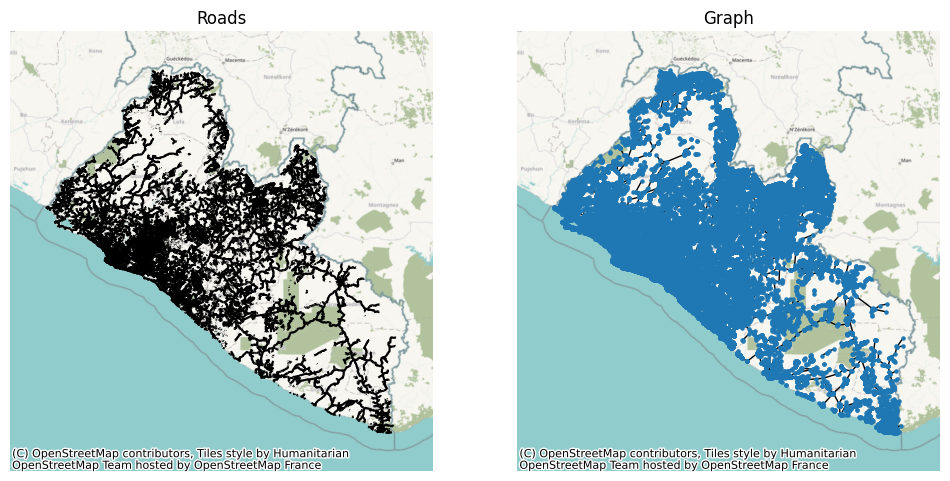

In [ ]:
g = momepy.gdf_to_nx(roads)
positions = {n: [n[0], n[1]] for n in list(g.nodes)}

f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
roads.plot(color="k", ax=ax[0])
nx.draw(g, positions, ax=ax[1], node_size=5)

for i, facet in enumerate(ax):
    facet.set_title(("Roads", "Graph")[i])
    facet.axis("off")
    add_basemap(ax[i], crs=roads.crs)


###3\. Реализовать алгоритм создания случайного, полносвязного графов и графа ближайшего соседства для узлов, сгенерированных на основе географической привязки методами networkx.

In [ ]:
def draw_graph(g, source):
    positions = {n: [n[0], n[1]] for n in list(g.nodes)}

    f, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
    nx.draw(g, positions, ax=ax, node_size=5)
    add_basemap(ax, crs=source.crs)

/usr/local/lib/python3.10/dist-packages/momepy/utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
124750it [00:00, 414583.02it/s]


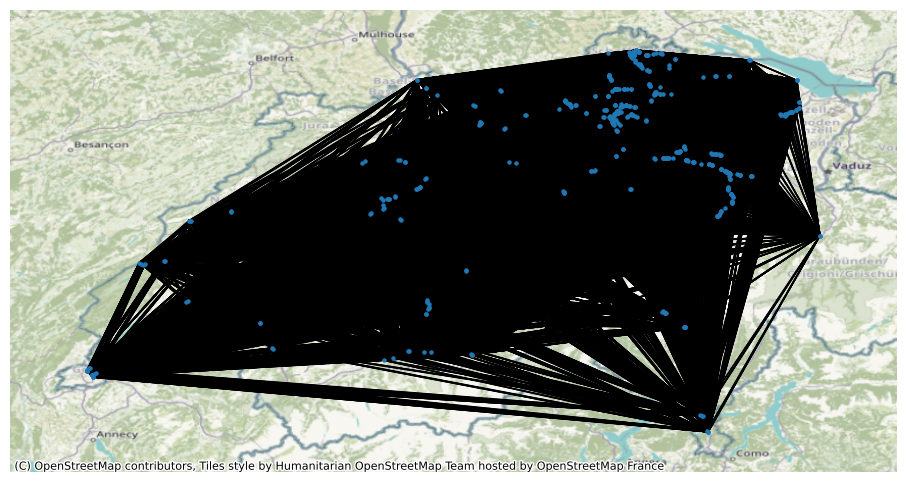

In [ ]:
def random_graph(nodes, p = 0.01):
    graph = nx.Graph()
    for pair in tqdm(itertools.combinations(nodes, 2)):
        if random.random() > p:
            graph.add_edge(pair[0], pair[1])
    return graph

rails_g = momepy.gdf_to_nx(rails_1)
draw_graph(random_graph(list(rails_g.nodes())[:500]), rails_1)

/usr/local/lib/python3.10/dist-packages/momepy/utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
/usr/local/lib/python3.10/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


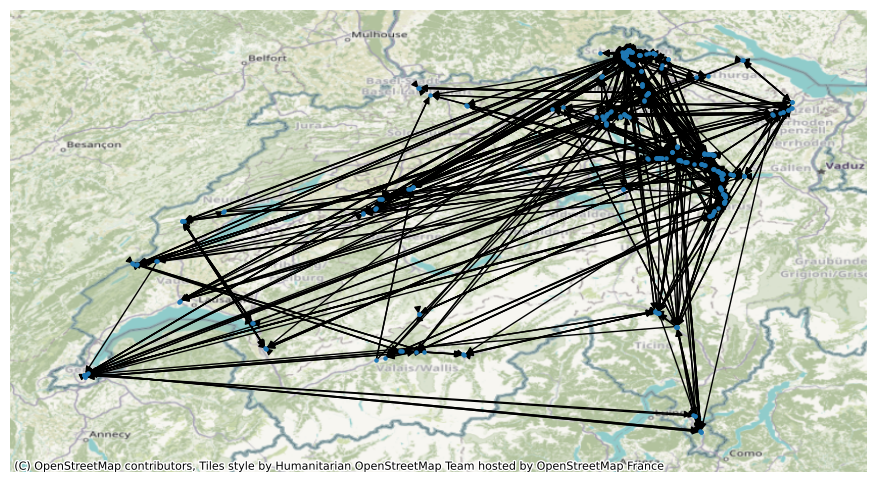

In [ ]:
rails_g = momepy.gdf_to_nx(rails_1[:300])
knn3 = weights.KNN.from_dataframe(rails_1[:300], k=3)
knn_graph = knn3.to_networkx()
positions = dict(zip(knn_graph.nodes, rails_g.nodes))

f, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
nx.draw(knn_graph, positions, ax=ax, node_size=5)
add_basemap(ax, crs=rails_1.crs)

###4\. Рассчитать среднюю степень вершины, средний минимальный путь и диаметр полученного графа.

/usr/local/lib/python3.10/dist-packages/momepy/utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


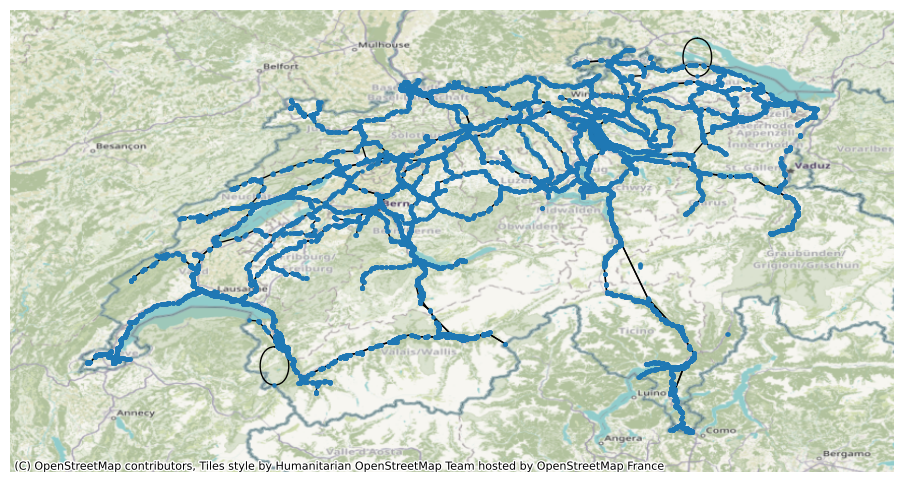

In [ ]:
rails_4 = momepy.gdf_to_nx(rails_1)
draw_graph(rails_4, rails_1)

In [ ]:
sum(dict(rails_4.degree()).values()) / len(rails_4)

1.9483255038642218

In [ ]:
sub = rails_4.subgraph(list(nx.connected_components(rails_4))[0])
len(sub)

26726

In [ ]:
nx.average_shortest_path_length(sub)

In [ ]:
nx.diameter(sub)

###5\. Проанализировать и выявить закономерности при их наличии (например, специфика регионов и т.п.)

In [ ]:
# partition = nx.community.girvan_newman(sub)

In [ ]:
# next(partition)

In [ ]:
# partition = nx.community.girvan_newman(sub)
# # partition = [*partition]


# positions = {n: [n[0], n[1]] for n in list(sub.nodes)}

# # f, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
# # nx.draw(sub, positions, ax=ax, node_size=5)
# # nx.draw(sub, positions, ax=ax, node_size=5)
# # add_basemap(ax, crs=rails_1.crs)

In [ ]:
# len(partition)